In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
def vertical_boundary_tensor_image():
    vertical_boundary_image = [[]] 
    boundary_position = random.randint(1, 255)
    for pixel_row in range(256):
        vertical_boundary_image[0].append([])
        for pixel_column in range(256):
            if pixel_column < boundary_position:
                vertical_boundary_image[0][pixel_row].append(np.float32(1))
            else:
                vertical_boundary_image[0][pixel_row].append(np.float32(0))

    vertical_boundary_tensor = torch.tensor(vertical_boundary_image)
    return vertical_boundary_tensor

def horizontal_boundary_tensor_image():
    horizontal_boundary_image = [[]] 
    boundary_position = random.randint(1, 255)
    for pixel_row in range(256):
        horizontal_boundary_image[0].append([])
        if pixel_row < boundary_position:
            for pixel_column in range(256):
                horizontal_boundary_image[0][pixel_row].append(np.float32(1))
        else:
            for pixel_column in range(256):
                horizontal_boundary_image[0][pixel_row].append(np.float32(0))

    horizontal_boundary_tensor = torch.tensor(horizontal_boundary_image)
    return horizontal_boundary_tensor

In [6]:
class DummyDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.all_imgs = []
        for i in range(50):
            self.all_imgs.append(vertical_boundary_tensor_image())
            self.all_imgs.append(horizontal_boundary_tensor_image())

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        tensor_image = self.all_imgs[idx]
        return tensor_image, tensor_image

In [7]:
full_dataset = DummyDataset()

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=full_dataset,
                                          batch_size=64,
                                          shuffle=True)

In [9]:
dataiter = iter(data_loader)
images, labels = dataiter.__next__()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [18]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [19]:
# Point to training loop video
num_epochs = 15
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.2540
Epoch:2, Loss:0.2207
Epoch:3, Loss:0.1912
Epoch:4, Loss:0.1622
Epoch:5, Loss:0.1460
Epoch:6, Loss:0.1204
Epoch:7, Loss:0.0704
Epoch:8, Loss:0.0488
Epoch:9, Loss:0.0344
Epoch:10, Loss:0.0242
Epoch:11, Loss:0.0135
Epoch:12, Loss:0.0099
Epoch:13, Loss:0.0086
Epoch:14, Loss:0.0065
Epoch:15, Loss:0.0077


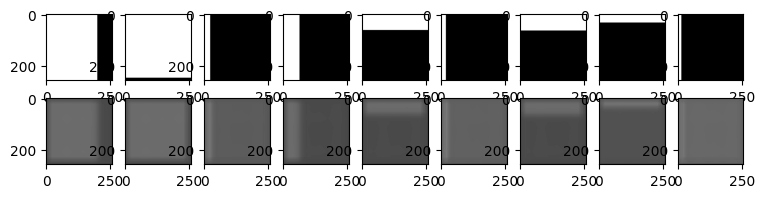

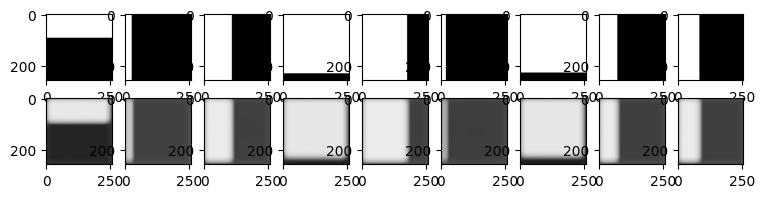

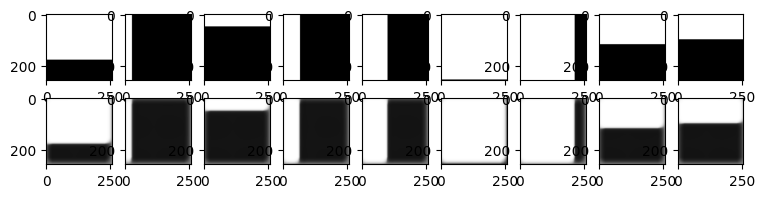

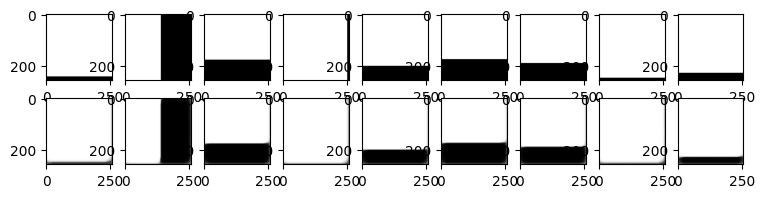

In [20]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])